In [1]:
# original size 258866 # 258841 # 258816
import sys
import os
from torch.utils.data import DataLoader
sys.path.append("..")
from tqdm import tqdm
import shutil
import torch
import numpy as np
import pandas as pd

from utils import train_test_split, create_metadata_df
from dataset_xy import CARLADatasetXY
from data_preprocessing import preprocessing
import json
from send2trash import send2trash

In [2]:
path_data = os.path.join("..", "..", "data", "data")

config_xy = {"used_inputs": ["rgb", "measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "y": ["brake", "steer", "throttle"],
        "seq_len": 1
        }

# Create df_meta 
# df_meta_data = create_metadata_df(path_data, config_xy["used_inputs"])
df_meta_data = pd.read_json("df_meta_data.json")


# Create Dataset & DataLoader
#dataset = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data, config=config_xy)

In [12]:
#dl = DataLoader(dataset=dataset, batch_size=64, num_workers=0, sampler=None, shuffle=False)

In [4]:
df_measurements = pd.read_json("df_measurements.json")

## Create distributions for entire dataset

Index(['dir', 'speed', 'command', 'steer', 'throttle', 'brake'], dtype='object')
dir         object
speed        int32
command      int32
steer        int32
throttle     int32
brake        int32
dtype: object


array([[<AxesSubplot:title={'center':'speed'}>,
        <AxesSubplot:title={'center':'command'}>],
       [<AxesSubplot:title={'center':'steer'}>,
        <AxesSubplot:title={'center':'throttle'}>],
       [<AxesSubplot:title={'center':'brake'}>, <AxesSubplot:>]],
      dtype=object)

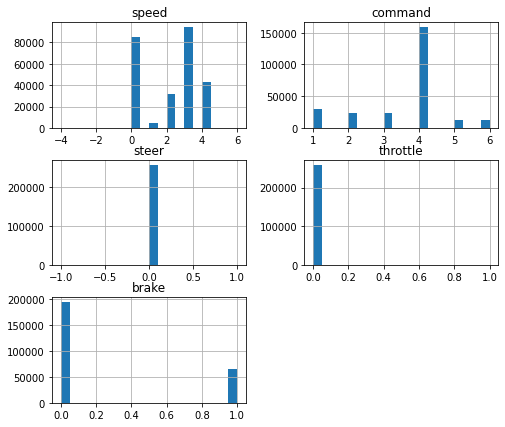

In [6]:
print(df_measurements.keys())
for index in range(1,6):
    df_measurements[df_measurements.keys()[index]] = df_measurements[df_measurements.keys()[index]].astype('int32')
print(df_measurements.dtypes)
df_measurements.hist(figsize=(8, 7), bins=20)


## Create distributions for train and test set separately (they should be similar)

In [9]:
df_meta_data_train, df_meta_data_test = train_test_split(df_meta_data, towns={"train": ["Town04"], "test": ["Town05"]}) # "Town06"
df_meta_data_test = df_meta_data_test.sample(n=int(df_meta_data_train.shape[0] * 0.15), random_state=3)

TypeError: train_test_split() got an unexpected keyword argument 'towns'

In [17]:
df_meta_data.to_pickle("df_meta_data.pickle")

In [37]:
df_measurements.to_json("df_measurements.json")

In [39]:
pd.read_json("df_measurements.json")

,dir,speed,command,steer,throttle,brake
0,../../data/data/cycl_dataset_23_11/Routes_non-...,0.000000e+00,4,0.000,0.000000,True
1,../../data/data/cycl_dataset_23_11/Routes_non-...,1.304910e-05,4,0.000,0.000000,True
2,../../data/data/cycl_dataset_23_11/Routes_non-...,0.000000e+00,4,0.000,0.000000,True
3,../../data/data/cycl_dataset_23_11/Routes_non-...,1.520000e-08,4,0.000,0.000000,True
4,../../data/data/cycl_dataset_23_11/Routes_non-...,1.490000e-08,4,0.000,0.000000,True
...,...,...,...,...,...,...
258811,../../data/data/dirt_dataset_23_11/Routes_Scen...,3.875880e+00,4,0.000,0.608982,False
258812,../../data/data/dirt_dataset_23_11/Routes_Scen...,3.736651e+00,4,-0.001,0.750000,False
258813,../../data/data/dirt_dataset_23_11/Routes_Scen...,4.154940e+00,4,0.000,0.056921,False
258814,../../data/data/dirt_dataset_23_11/Routes_Scen...,3.741420e+00,4,0.000,0.750000,False


In [38]:
df_meta_data.to_json("df_meta_data.json")

array([[<AxesSubplot: title={'center': 'speed'}>,
        <AxesSubplot: title={'center': 'command'}>],
       [<AxesSubplot: title={'center': 'steer'}>,
        <AxesSubplot: title={'center': 'throttle'}>]], dtype=object)

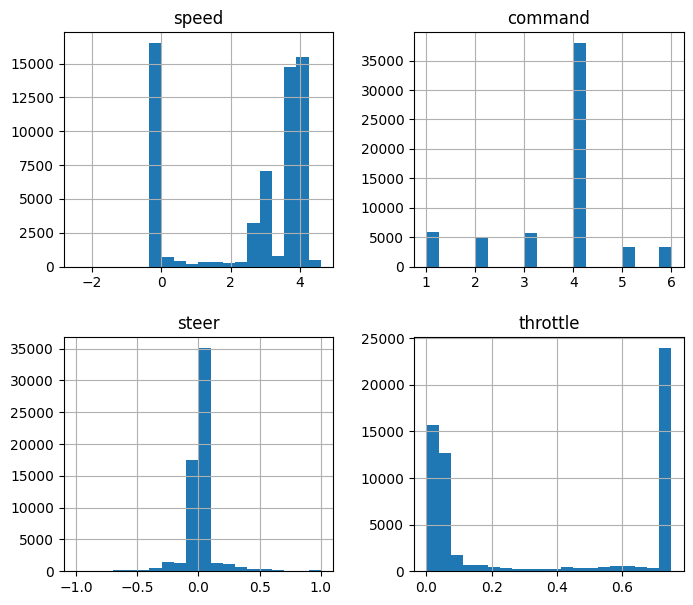

In [18]:
df_measurements_train = df_measurements[df_measurements.index.isin(df_meta_data_train.index)]
df_measurements_train.hist(figsize=(8, 7), bins=20)

array([[<AxesSubplot: title={'center': 'speed'}>,
        <AxesSubplot: title={'center': 'command'}>],
       [<AxesSubplot: title={'center': 'steer'}>,
        <AxesSubplot: title={'center': 'throttle'}>]], dtype=object)

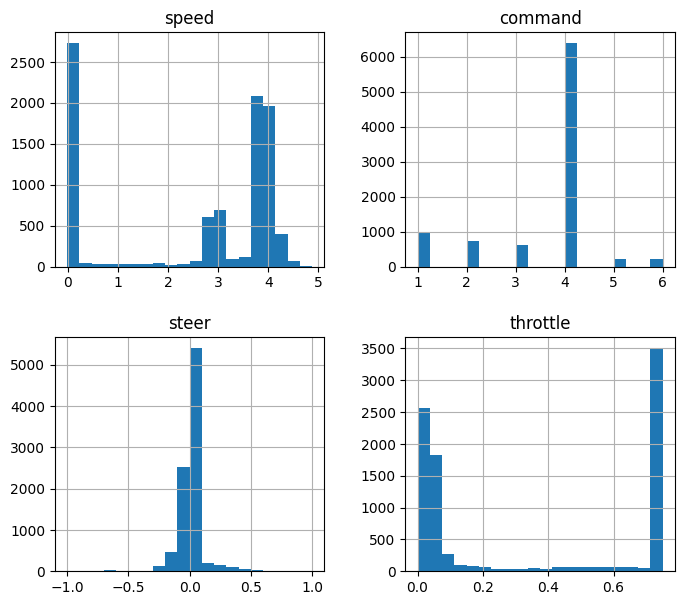

In [19]:
df_measurements_test = df_measurements[df_measurements.index.isin(df_meta_data_test.index)]
df_measurements_test.hist(figsize=(8, 7), bins=20)

In [20]:
df_measurements.describe()

,speed,command,steer,throttle
count,2.588160e+05,258816.000000,258816.000000,258816.000000
mean,2.382342e+00,3.521227,0.000917,0.347406
std,1.724863e+00,1.216411,0.127009,0.346908
min,-4.490779e+00,1.000000,-1.000000,0.000000
25%,5.878689e-08,3.000000,-0.005500,0.000000
50%,3.082393e+00,4.000000,0.000000,0.105180
75%,3.861653e+00,4.000000,0.002000,0.750000
max,6.353220e+00,6.000000,1.000000,1.150000


## Create classes manually (outdated --> rather use histograms --> see below)

In [21]:
freq_classes = {"steer":{
                            "1": (lambda ser: ser.between(-1.1, -0.4, inclusive="left")),
                            "2": (lambda ser: ser.between(-0.4, -0.1, inclusive="left")),
                            "3": (lambda ser: ser.between(-0.1, 0.1, inclusive="left")),
                            "4": (lambda ser: ser.between(0.1, 0.4, inclusive="left")),
                            "5": (lambda ser: ser.between(0.4, 1.1, inclusive="left")),
                        }
                }               

In [22]:
def steer_classifier(steer):
    if -1 <= steer < -0.4:
        return 1
    elif -0.4 <= steer < -0.1:
        return 2
    elif -0.1 <= steer < 0.1:
        return 3
    elif 0.1 <= steer < 0.4:
        return 4
    elif 0.4 <= steer < 1.1:
        return 5

In [23]:
df_measurements["steer"].apply(steer_classifier)# .plot(kind="pie")

0         3
1         3
2         3
3         3
4         3
         ..
258811    3
258812    3
258813    3
258814    3
258815    3
Name: steer, Length: 258816, dtype: int64

In [24]:
ser_temp = []
for key_class in freq_classes["steer"]:
    ser = freq_classes["steer"][key_class](df_measurements["steer"])
    ser.name = key_class
    ser_temp.append(ser)

In [25]:
df_classes = pd.concat(ser_temp, axis=1)
df_classes_check = df_classes.sum(axis=1)

In [26]:
# df_meta_data.to_pickle("meta_data_entire.pickle")

## Creating classes using histograms & first weight calculations

In [27]:
hist, bin_edges = np.histogram(df_measurements["steer"], bins=5)
bin_edges[-1] = 1.1

In [28]:
bin_mapping = np.digitize(df_measurements["steer"], bins=bin_edges,)
bin_mapping_count = pd.DataFrame(bin_mapping).value_counts(normalize=True).sort_index()

In [29]:
bin_mapping_weighted = np.zeros(len(bin_mapping))
for idx, bin_map in enumerate(bin_mapping):
    bin_mapping_weighted[idx] = bin_mapping_count.loc[bin_map]

In [30]:
bin_mapping_weighted = 1 / bin_mapping_weighted

In [31]:
# (bin_mapping_weighted / bin_mapping_weighted.sum()).sum() = 1
sample_weights_entire = (bin_mapping_weighted / bin_mapping_weighted.sum())

In [55]:
# (bin_mapping_weighted[:64] / bin_mapping_weighted[:64].sum()).sum() = 1
sample_weights_first_batch = (bin_mapping_weighted[:64] / bin_mapping_weighted[:64].sum())